dict_keys(['ztop', 'time', 'xh', 'xf', 'yh', 'yf', 'zh', 'zf', 'umove', 'vmove', 'rain', 'prate', 'sws', 'svs', 'sps', 'srs', 'sgs', 'sus', 'shs', 'rain2', 'sws2', 'svs2', 'sps2', 'srs2', 'sgs2', 'sus2', 'shs2', 'cpc', 'cph', 'cref', 'th', 'prs', 'qv', 'qc', 'qr', 'qi', 'qs', 'qg', 'nci', 'ncs', 'ncr', 'ncg', 'dbz', 'uinterp', 'vinterp', 'winterp', 'u', 'v', 'w', 'tke', 'kmh', 'kmv', 'khh', 'khv'])


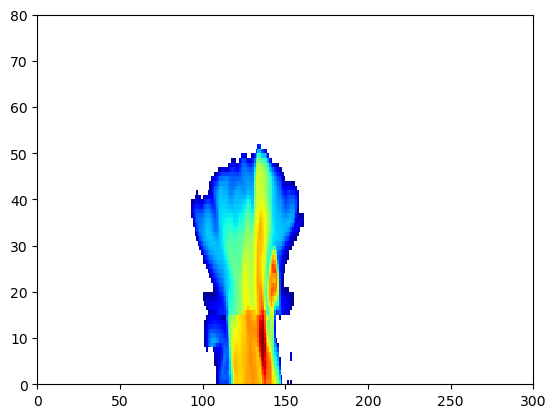

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np

with Dataset('output/cm1out.nc') as f:
    print(f.variables.keys())
    
    dbz=f['dbz'][:,:,:,:]
    dbz=np.ma.array(dbz,mask=dbz<10)
    qr=f['qr'][:,:,:,:]
    qs=f['qs'][:,:,:,:]
    qg=f['qg'][:,:,:,:]
    qc=f['qc'][:,:,:,:]
    qv=f['qv'][:,:,:,:]
    T=f['th'][:,:,:,:]
    press=f['prs'][:,:,:,:]
    ncr=f['ncr'][:,:,:,:]
    ncs=f['ncs'][:,:,:,:]
    ncg=f['ncg'][:,:,:,:]

plt.pcolormesh(dbz[-5,:,30,:],cmap='jet')
T=T*(press/100000)**(287/1004)


In [44]:
import lkTables
lkTables=lkTables.scattTables() 
from bisectm import bisectm

def simZKu(gwc,swc,rwc,dmg,dms,dmr,dr):
    n1=gwc.shape[0]
    piaKu=0
    piaKa=0
    zKuSim=np.zeros((n1),float)-99
    zKu_true=np.zeros((n1),float)-99
    zKaSim=np.zeros((n1),float)-99
    zKa_true=np.zeros((n1),float)-99
    kexttot=np.zeros((n1),float)
    salbtot=np.zeros((n1),float)
    asymtot=np.zeros((n1),float)
    
    nfreqm=8
    kext1D=np.zeros((n1,nfreqm),float)
    salb1D=np.zeros((n1,nfreqm),float)
    asym1D=np.zeros((n1,nfreqm),float)
    for k1 in range(n1-1,-1,-1):
        attKu=0
        attKa=0
        zku=0
        zka=0
        dns=0
        dng=0
        if k1<40:
            dns=-(40-max(k1,22))*0.075
        if k1<80 and k1>0:
            dng=-(24-k1)*0.075
        dng=max(-0.97,dng)
        dng=min(0.97,dng)
        #dns=0
        #dng=0
        dms[k1]=max(lkTables.dms[0],dms[k1])
        dms[k1]=min(dms[k1],lkTables.dms[-1])
        dmg[k1]=max(lkTables.dmg[0],dmg[k1])
        dmg[k1]=min(dmg[k1],lkTables.dmg[-1])
        dmr[k1]=max(lkTables.dmr[0],dmr[k1])
        dmr[k1]=min(dmr[k1],lkTables.dmr[-1])
        if gwc[k1]>0:
            #ind=bisectm(lkTables.gwc.data,272,gwc[k1]/10**dng)
            ind=bisectm(lkTables.dmg.data,272,dmg[k1])
            dng=np.log10(gwc[k1]/lkTables.gwc.data[ind])
            zKug=lkTables.zKuG[ind]+10*dng
            zKag=lkTables.zKaG[ind]+10*dng
            attKug=lkTables.attKuG[ind]*10**dng
            attKag=lkTables.attKaG[ind]*10**dng
            attKu+=attKug
            attKa+=attKag
            zku+=10**(0.1*zKug)
            zka+=10**(0.1*zKag)
            kext1D[k1,:]+=lkTables.kextG[ind,:]*10**dng
            salb1D[k1,:]+=lkTables.kextG[ind,:]*10**dng*lkTables.salbG[ind,:]
            asym1D[k1,:]+=lkTables.kextG[ind,:]*10**dng*lkTables.salbG[ind,:]*lkTables.asymG[ind,:]
        if swc[k1]>0:
            ind=bisectm(lkTables.dms.data,253,dms[k1])
            dns=np.log10(swc[k1]/lkTables.swc.data[ind])
            zKus=lkTables.zKuS[ind]+10*dns
            zKas=lkTables.zKaS[ind]+10*dns
            attKus=lkTables.attKuS[ind]*10**dns
            attKas=lkTables.attKaS[ind]*10**dns
            attKu+=attKus
            attKa+=attKas
            zku+=10**(0.1*zKus)
            zka+=10**(0.1*zKas)
            kext1D[k1,:]+=lkTables.kextS[ind,:]*10**dns
            salb1D[k1,:]+=lkTables.kextS[ind,:]*10**dns*lkTables.salbS[ind,:]
            asym1D[k1,:]+=lkTables.kextS[ind,:]*10**dns*lkTables.salbS[ind,:]*lkTables.asymS[ind,:]
        if rwc[k1]>0:
            ind=bisectm(lkTables.dmr.data,289,dmr[k1])
            dnr=np.log10(rwc[k1]/lkTables.rwc.data[ind])
            #ind=bisectm(lkTables.rwc.data,289,rwc[k1])
            zKur=lkTables.zKuR[ind]+10*dnr
            zKar=lkTables.zKaR[ind]+10*dnr
            attKur=lkTables.attKuR[ind]*10**dnr
            attKar=lkTables.attKaR[ind]*10**dnr
            attKu+=attKur
            attKa+=attKar
            zku+=10**(0.1*zKur)
            zka+=10**(0.1*zKar)
            kext1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr
            salb1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]
            asym1D[k1,:]+=lkTables.kextR[ind,:]*10**dnr*lkTables.salbR[ind,:]*lkTables.asymR[ind,:]
        if attKu>0:
            piaKu+=attKu*dr
            piaKa+=attKa*dr
            zKuSim[k1]=10*np.log10(zku)-piaKu
            zKaSim[k1]=10*np.log10(zka)-piaKa
            zKu_true[k1]=10*np.log10(zku)
            zKa_true[k1]=10*np.log10(zka)
            piaKu+=attKu*dr
            piaKa+=attKa*dr
    kexttot[:]=kext1D[:,3]+1e-4
    salbtot[:]=salb1D[:,3]#/kexttot[:]
    asymtot[:]=asym1D[:,3]/(salb1D[:,3]+1e-4)      
    n1=80
    noms=0
    alt=400
    freqKa=35.5
    nonorm=1
    theta=0.5
    #print(kexttot[0:n1].sum()*dr*4.343*2,piaKa)
    #print(salbtot.max(),salbtot.min())
    #print(asymtot.max(),asymtot.min())
    #stop
    zms = libSc.multiscatterf(kexttot[0:n1][::-1],salbtot[0:n1][::-1],asymtot[0:n1][::-1],\
                            zKa_true[0:n1][::-1],dr,noms,alt,theta,freqKa,nonorm)
    
    return zKuSim,zKu_true,piaKu,zKaSim,zKa_true,piaKa,zms[::-1]


In [48]:
#!ls cm1out*nc
def readCM1(fname):
    with Dataset(fname) as f:
        dbz=f['dbz'][:,:,:,:]
        dbz=np.ma.array(dbz,mask=dbz<10)
        qr=f['qr'][:,:,:,:]
        qs=f['qs'][:,:,:,:]
        qg=f['qg'][:,:,:,:]
        qc=f['qc'][:,:,:,:]
        qv=f['qv'][:,:,:,:]
        T=f['th'][:,:,:,:]
        press=f['prs'][:,:,:,:]
        ncr=f['ncr'][:,:,:,:]
        ncs=f['ncs'][:,:,:,:]
        ncg=f['ncg'][:,:,:,:]
    return dbz,qr,qs,qg,qc,qv,T,press,ncr,ncs,ncg

import tqdm
ntot=0
rhog=400
rhos=100
rhow=1000

def calcObs(qg,qs,qr,rhog,rhos,rhow,ncg,rho,ntot):
    nz,ny,nx=qg.shape
    zKu=np.zeros((nz,ny,nx),float)-99
    zKa=np.zeros((nz,ny,nx),float)-99
    zKu_true=np.zeros((nz,ny,nx),float)-99
    zKa_true=np.zeros((nz,ny,nx),float)-99
    piaKu=np.zeros((ny,nx),float)
    piaKa=np.zeros((ny,nx),float)
    a=np.nonzero(dbz[0,:,:,:].max(axis=0)>0)
    print(len(a[0]))
    ntot+=len(a[0])
    for i1, j1 in tqdm.tqdm(zip(a[0][:1],a[1][:1])):
        gwc=qg[0,:,i1,j1]*rho[0,:,i1,j1]*1e3
        swc=qs[0,:,i1,j1]*rho[0,:,i1,j1]*1e3
        rwc=qr[0,:,i1,j1]*rho[0,:,i1,j1]*1e3
        dms=np.zeros((80),float)
        dmg=np.zeros((80),float)
        dmr=np.zeros((80),float)
        a1=np.nonzero(gwc>0)
        dmg[a1]=4/(ncg[0,a1,i1,j1]*3.1415*rhog/qg[0,a1,i1,j1])**0.333*1e3
        a1=np.nonzero(swc>0)
        dms[a1]=4/(ncs[0,a1,i1,j1]*3.1415*rhos/qs[0,a1,i1,j1])**0.333*1e3
        a1=np.nonzero(rwc>0)
        dmr[a1]=4/(ncr[0,a1,i1,j1]*3.1415*rhow/qr[0,a1,i1,j1])**0.333*1e3
        zku1,zku1_true,piaKu1,zka1,zka1_true,piaKa1,zms=simZKu(gwc,swc,rwc,dmg,dms,dmr,0.25)
        zKu[:,i1,j1]=zku1
        zKu_true[:,i1,j1]=zku1_true
        zKa[:,i1,j1]=zms
        zKa_true[:,i1,j1]=zka1_true
        piaKu[i1,j1]=piaKu1
        piaKa[i1,j1]=piaKa1
    return zKu,zKu_true,zKa,zKa_true,piaKu,piaKa,ntot

for i in range(20,21):
    fname='cm1out_0000%2.2i.nc'%i
    dbz,qr,qs,qg,qc,qv,T,press,ncr,ncs,ncg=readCM1(fname)
    T=T*(press/100000)**(287/1004)
    rho=press/(287*T)
    zKu,zKu_true,zKa,zKa_true,piaKu,piaKa,ntot=calcObs(qg,qs,qr,rhog,rhos,rhow,ncg,rho,ntot)
    print(ntot)


    

4092
4189
4271
4353
4448
4535
4664
4839
5017
5208
45616


1it [00:00, 153.62it/s]


In [47]:
print(len(a[0]))

4092


In [18]:
cfad=np.zeros((80,50))
plt.figure()
ntot=0

    #for i1,j1 in zip(a[0],a[1]):
    #    plt.plot(dbz[:,i1,j1],np.arange(80)*0.25,'*',markersize=1)
    #for k in range(80):
    #    cfad[k,:]=np.histogram(dbz[i,k,:,:][a],bins=50,range=(10,60))[0]

print(ntot)

1097
1097


<Figure size 640x480 with 0 Axes>

In [3]:
#print(T[i,:,a[0][0],a[1][0]])
#print(press[i,:,a[0][0],a[1][0]])
import importlib
import lkTables
importlib.reload(lkTables)
lkTables=lkTables.scattTables()
import libScatter as libSc
print(lkTables.gwc[100:110])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): dim_0(289), dim_1(8)
    variables(dimensions): float32 kextR(dim_0, dim_1), float32 salbR(dim_0, dim_1), float32 asymR(dim_0, dim_1), float32 kextS(dim_0, dim_1), float32 salbS(dim_0, dim_1), float32 asymS(dim_0, dim_1), float32 kextG(dim_0, dim_1), float32 salbG(dim_0, dim_1), float32 asymG(dim_0, dim_1)
    groups: 
[0.0479     0.0495     0.05120001 0.0529     0.05469999 0.05650001
 0.0584     0.06049999 0.06249999 0.0646    ]


In [37]:


zKuL=[]
zKu_trueL=[]
zKaL=[]
zKa_trueL=[]
piaKuL=[]
piaKaL=[]
import tqdm 
ntot=0
rhow=1000
rhos=100
rhog=400
dmgL=[]
dmrL=[]
dmsL=[]
for i in range(-6,-2):
    a=np.nonzero(dbz[i,22,:,:]>25)
    print(len(a[0]))
    ntot+=len(a[0])
    for i1, j1 in tqdm.tqdm(zip(a[0],a[1])):
        gwc=qg[i,:,i1,j1]*rho[i,:,i1,j1]*1e3
        swc=qs[i,:,i1,j1]*rho[i,:,i1,j1]*1e3
        rwc=qr[i,:,i1,j1]*rho[i,:,i1,j1]*1e3
        dms=np.zeros((80),float)
        dmg=np.zeros((80),float)
        dmr=np.zeros((80),float)
        a1=np.nonzero(gwc>0)
        dmg[a1]=4/(ncg[i,a1,i1,j1]*3.1415*rhog/qg[i,a1,i1,j1])**0.333*1e3
        dmgL.append(dmg[a1].mean())
        a1=np.nonzero(swc>0)
        dms[a1]=4/(ncs[i,a1,i1,j1]*3.1415*rhos/qs[i,a1,i1,j1])**0.333*1e3
        dmsL.append(dms[a1].mean())
        a1=np.nonzero(rwc>0)
        dmr[a1]=4/(ncr[i,a1,i1,j1]*3.1415*rhow/qr[i,a1,i1,j1])**0.333*1e3
        dmrL.append(dmr[a1].mean())
        zku1,zku1_true,piaKu,zka1,zka1_true,piaKa,zms=simZKu(gwc,swc,rwc,dmg,dms,dmr,0.25)
        zKuL.append(zku1)
        zKu_trueL.append(zku1_true)
        piaKuL.append(piaKu)
        zKaL.append(zka1)
        zKa_trueL.append(zms)
        piaKaL.append(piaKa)

1475


1475it [00:18, 79.20it/s]


1912


1912it [00:23, 81.91it/s]


2565


2565it [00:30, 84.50it/s]


3101


3101it [00:35, 86.60it/s]


In [158]:
print(np.mean(dmgL))
print(np.mean(dmrL))
print(np.mean(dmsL))
print(lkTables.dms[0],lkTables.dms[-1])
print(lkTables.dmg[0],lkTables.dmg[-1])
print(lkTables.dmr[0],lkTables.dmr[-1])


1.9694706537793008
1.4441790115057402
2.557239251640047
0.35477474 3.567132
0.365 3.927
0.30242458 3.0589707


9053
5.628347055324745
43.819081205109384


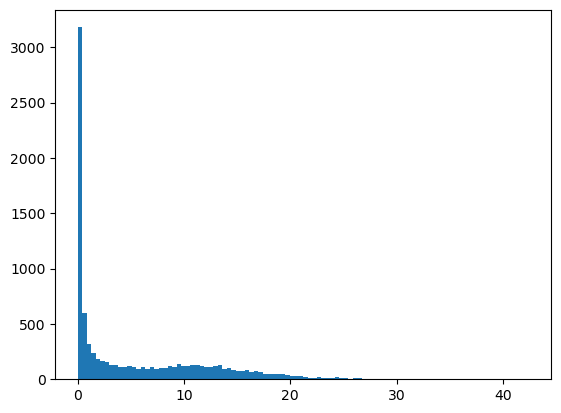

In [174]:
print(len(zKuL))
print(np.mean(piaKuL))
print(np.mean(piaKaL))
h1=plt.hist(piaKuL,bins=100)

In [39]:

cfadKu=np.zeros((80,50))
cfadKu_true=np.zeros((80,50))
cfadKa=np.zeros((80,50))
cfadKa_true=np.zeros((80,50))
zKuL=np.array(zKuL)
zKu_trueL=np.array(zKu_trueL)
zKaL=np.array(zKaL)
zKa_trueL=np.array(zKa_trueL)
for k in range(80):
    cfadKu[k,:]=np.histogram(zKuL[:,k],bins=50,range=(10,60))[0]
    cfadKu_true[k,:]=np.histogram(zKu_trueL[:,k],bins=50,range=(10,60))[0]
    cfadKa[k,:]=np.histogram(zKaL[:,k],bins=50,range=(10,60))[0]
    cfadKa_true[k,:]=np.histogram(zKa_trueL[:,k],bins=50,range=(10,60))[0]

9053


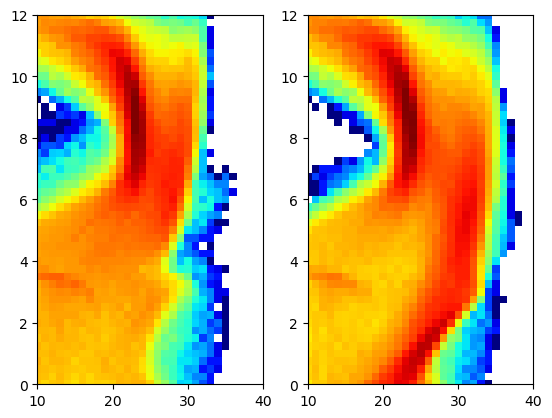

In [40]:

plt.figure()
from matplotlib.colors import LogNorm
plt.subplot(121)
plt.pcolormesh(np.arange(50)*1.0+10,np.arange(80)*0.25,cfadKa,cmap='jet',norm=LogNorm())
plt.ylim(0,12)
plt.xlim(10,40)
plt.subplot(122)
plt.pcolormesh(np.arange(50)*1.0+10,np.arange(80)*0.25,cfadKa_true,cmap='jet',norm=LogNorm())
plt.ylim(0,12)
plt.xlim(10,40)
print(ntot)

In [16]:
print(lkTables.salbG[:272,3])

[0.6        0.6        0.6        0.6        0.5        0.5
 0.6666666  0.57142854 0.57142854 0.57142854 0.625      0.625
 0.625      0.5555555  0.6666667  0.6        0.70000005 0.6363636
 0.6363636  0.6666666  0.6666666  0.6923077  0.64285713 0.7142857
 0.6666667  0.6875     0.75       0.7058824  0.7222222  0.73684216
 0.75       0.71428573 0.72727275 0.73913044 0.72       0.7307692
 0.7407407  0.7586207  0.7666667  0.75       0.76470584 0.7714285
 0.7837838  0.7948718  0.78048784 0.77272725 0.7826087  0.7916666
 0.8039216  0.7962963  0.80701756 0.8000001  0.8095238  0.8181818
 0.8142857  0.82432425 0.82051283 0.82926834 0.83720934 0.8351648
 0.84374994 0.84158415 0.8411215  0.8495575  0.8487395  0.85599995
 0.8560606  0.8571428  0.8639456  0.86451614 0.8658537  0.8728324
 0.8688525  0.8756477  0.88177335 0.8790698  0.88105726 0.8870293
 0.8888889  0.8876405  0.8932384  0.8956229  0.8949044  0.9003022
 0.9000001  0.90243906 0.90512824 0.9053398  0.908046   0.9106754
 0.9113402  0.9140

(-20.0, 50.0)

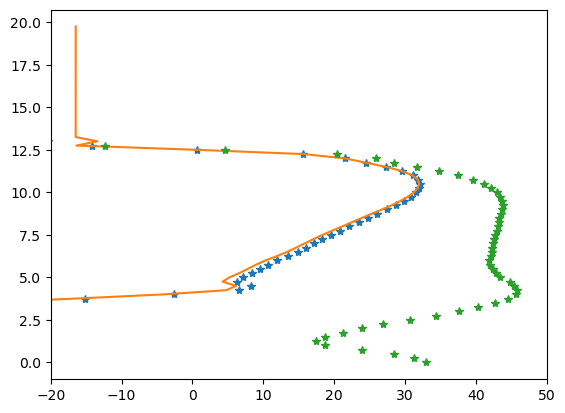

In [36]:
plt.plot(zKaL[100,:],np.arange(80)*0.25,'*')
plt.plot(zKa_trueL[100,:],np.arange(80)*0.25,'-')
plt.plot(zKuL[100,:],np.arange(80)*0.25,'*')
plt.xlim(-20,50)

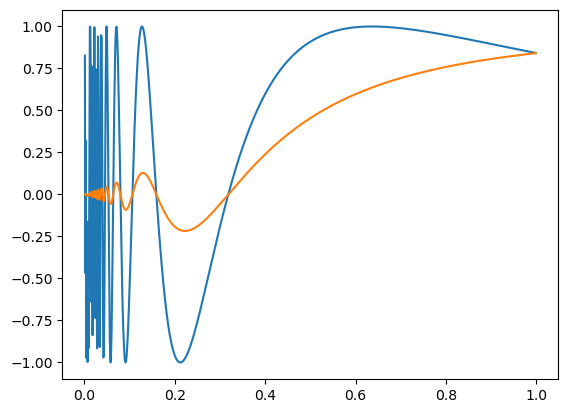

In [22]:
x=np.arange(1,1000)/1e3

y=np.sin(1/x)
plt.plot(x,y)
plt.plot(x,x*y)